In [39]:
# Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn

In [63]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

In [64]:
# Load the data with proper numeric handling
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)

In [65]:
# Improved preprocessing with safe numeric conversion
def preprocess_data(df):
    # Convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

    # Safely convert amount and assetPriceUSD to float
    def safe_convert(x, key):
        try:
            return float(x['actionData'][key])
        except (ValueError, KeyError):
            return 0.0

    df['amount'] = df.apply(lambda x: safe_convert(x, 'amount'), axis=1)
    df['assetPriceUSD'] = df.apply(lambda x: safe_convert(x, 'assetPriceUSD'), axis=1)

    # Calculate USD value
    df['usd_value'] = df['amount'] * df['assetPriceUSD']

    # Extract relevant features
    df['action_type'] = df['action']
    df['asset_symbol'] = df['actionData'].apply(lambda x: x.get('assetSymbol', 'UNKNOWN'))

    return df


In [66]:
def calculate_wallet_features(df):
    # Group by wallet and calculate various metrics
    wallet_groups = df.groupby('userWallet')

    features = []

    for wallet, group in tqdm(wallet_groups):
        # Basic transaction counts
        tx_count = len(group)
        action_counts = group['action_type'].value_counts().to_dict()

        # Time-based features
        first_tx = group['datetime'].min()
        last_tx = group['datetime'].max()
        activity_duration = (last_tx - first_tx).total_seconds() / 86400  # in days

        # Value-based features
        total_usd_value = group['usd_value'].sum()
        avg_usd_value = group['usd_value'].mean()
        max_usd_value = group['usd_value'].max()

        # Deposit/borrow ratio
        deposit_value = group[group['action_type'] == 'deposit']['usd_value'].sum()
        borrow_value = group[group['action_type'] == 'borrow']['usd_value'].sum()
        repay_value = group[group['action_type'] == 'repay']['usd_value'].sum()

        if borrow_value > 0:
            borrow_repay_ratio = repay_value / borrow_value
            deposit_borrow_ratio = deposit_value / borrow_value
        else:
            borrow_repay_ratio = 1  # no borrowing is good
            deposit_borrow_ratio = 10  # high value indicates no borrowing

        # Liquidation features
        liquidation_count = (group['action_type'] == 'liquidationcall').sum()

        # Asset diversity
        asset_diversity = group['asset_symbol'].nunique()

        # Time between transactions
        time_diffs = group['datetime'].sort_values().diff().dt.total_seconds().dropna()
        if len(time_diffs) > 0:
            avg_time_between_txs = time_diffs.mean() / 3600  # in hours
            time_std = time_diffs.std() / 3600
        else:
            avg_time_between_txs = 0
            time_std = 0

        features.append({
            'wallet': wallet,
            'tx_count': tx_count,
            'deposit_count': action_counts.get('deposit', 0),
            'borrow_count': action_counts.get('borrow', 0),
            'repay_count': action_counts.get('repay', 0),
            'redeem_count': action_counts.get('redeemunderlying', 0),
            'liquidation_count': action_counts.get('liquidationcall', 0),
            'activity_duration_days': activity_duration,
            'total_usd_value': total_usd_value,
            'avg_usd_value': avg_usd_value,
            'max_usd_value': max_usd_value,
            'deposit_value': deposit_value,
            'borrow_value': borrow_value,
            'repay_value': repay_value,
            'borrow_repay_ratio': borrow_repay_ratio,
            'deposit_borrow_ratio': deposit_borrow_ratio,
            'asset_diversity': asset_diversity,
            'avg_time_between_txs_hours': avg_time_between_txs,
            'time_std_hours': time_std,
            'first_tx': first_tx,
            'last_tx': last_tx
        })

    return pd.DataFrame(features)

In [68]:
def generate_credit_scores(wallet_features):
    # Select base features
    feature_cols = [
        'tx_count',
        'deposit_count',
        'borrow_count',
        'repay_count',
        'redeem_count',
        'liquidation_count',
        'activity_duration_days',
        'total_usd_value',
        'avg_usd_value',
        'max_usd_value',
        'borrow_repay_ratio',
        'deposit_borrow_ratio',
        'asset_diversity',
        'avg_time_between_txs_hours',
        'time_std_hours'
    ]

    # Enhanced value transformation
    def safe_transform(x):
        return np.sign(x) * np.log1p(np.log1p(np.log1p(np.abs(x))))

    monetary_cols = ['total_usd_value', 'avg_usd_value', 'max_usd_value']
    for col in monetary_cols:
        wallet_features[col] = wallet_features[col].apply(safe_transform)

    # Enhanced feature engineering
    wallet_features['tx_frequency'] = np.log1p(
        wallet_features['tx_count'] / wallet_features['activity_duration_days'].clip(lower=1)
    )

    # More sophisticated financial ratios
    wallet_features['health_ratio'] = np.log1p(
        (wallet_features['deposit_value'] + 1e6) /  # Add constant to avoid tiny values
        (wallet_features['borrow_value'] + 1e6)
    )

    wallet_features['repay_ratio'] = np.log1p(
        (wallet_features['repay_value'] + 1) /
        (wallet_features['borrow_value'].clip(lower=1) + 1e-6)
    )

    # Comprehensive behavior score
    wallet_features['behavior_score'] = (
        0.4 * wallet_features['health_ratio'] +
        0.3 * wallet_features['repay_ratio'] +
        0.2 * (1 - wallet_features['liquidation_count']/10) +  # Max 10% penalty
        0.1 * np.log1p(wallet_features['asset_diversity'])
    )

    # Update feature columns
    feature_cols.extend(['tx_frequency', 'health_ratio', 'repay_ratio'])

    # Advanced normalization
    from sklearn.preprocessing import QuantileTransformer
    qt = QuantileTransformer(output_distribution='normal')
    X = qt.fit_transform(wallet_features[feature_cols])

    # Final model configuration
    clf = IsolationForest(
        n_estimators=500,
        contamination=0.03,  # Very conservative outliers
        max_samples=128,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X)

    # Score calculation with better distribution
    raw_scores = clf.decision_function(X)
    anomaly_scores = MinMaxScaler(feature_range=(200, 800)).fit_transform(
        raw_scores.reshape(-1, 1)
    ).flatten()

    # Convert behavior_score to numpy array before reshaping
    behavior_score_values = wallet_features['behavior_score'].values
    behavior_scores = MinMaxScaler(feature_range=(100, 900)).fit_transform(
        behavior_score_values.reshape(-1, 1)
    ).flatten()

    # Final weighted score with non-linear combination
    credit_scores = np.clip(
        (anomaly_scores**0.7 * behavior_scores**0.3),  # Geometric mean
        150, 850  # Keep within reasonable bounds
    )

    # Apply final adjustments
    liquidation_penalty = 1 - (wallet_features['liquidation_count'].values * 0.15)
    credit_scores = (credit_scores * liquidation_penalty).clip(150, None)

    # Convert to 0-1000 scale
    wallet_features['credit_score'] = MinMaxScaler(feature_range=(0, 1000)).fit_transform(
        credit_scores.reshape(-1, 1)
    ).flatten().round(0).astype(int)

    return wallet_features

In [69]:
def analyze_scores(wallet_scores):
    # Create score bins
    bins = list(range(0, 1100, 100))
    labels = [f"{i}-{i+99}" for i in range(0, 1000, 100)]
    wallet_scores['score_range'] = pd.cut(wallet_scores['credit_score'], bins=bins, labels=labels, right=False)

    # Plot distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=wallet_scores, x='score_range', order=labels)
    plt.title('Credit Score Distribution')
    plt.xlabel('Credit Score Range')
    plt.ylabel('Number of Wallets')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('score_distribution.png')
    plt.show()

    # Analyze top and bottom wallets
    top_wallets = wallet_scores.nlargest(5, 'credit_score')
    bottom_wallets = wallet_scores.nsmallest(5, 'credit_score')

    print("\nTop 5 Wallets by Credit Score:")
    print(top_wallets[['wallet', 'credit_score', 'tx_count', 'deposit_value', 'borrow_value', 'liquidation_count']])

    print("\nBottom 5 Wallets by Credit Score:")
    print(bottom_wallets[['wallet', 'credit_score', 'tx_count', 'deposit_value', 'borrow_value', 'liquidation_count']])

    # Save analysis to markdown
    with open('analysis.md', 'w') as f:
        f.write("# Credit Score Analysis\n\n")
        f.write("## Score Distribution\n")
        f.write("![Score Distribution](score_distribution.png)\n\n")

        f.write("## Top Performing Wallets\n")
        f.write("These wallets exhibit responsible borrowing behavior with high deposit-to-borrow ratios:\n")
        f.write(top_wallets.to_markdown(index=False))
        f.write("\n\n")

        f.write("## Risky Wallets\n")
        f.write("These wallets show signs of risky behavior like high borrowing with low repayment:\n")
        f.write(bottom_wallets.to_markdown(index=False))

Loading data...
Preprocessing data...
Calculating wallet features...


100%|██████████| 3497/3497 [00:15<00:00, 218.86it/s]


Generating credit scores...
Analyzing results...


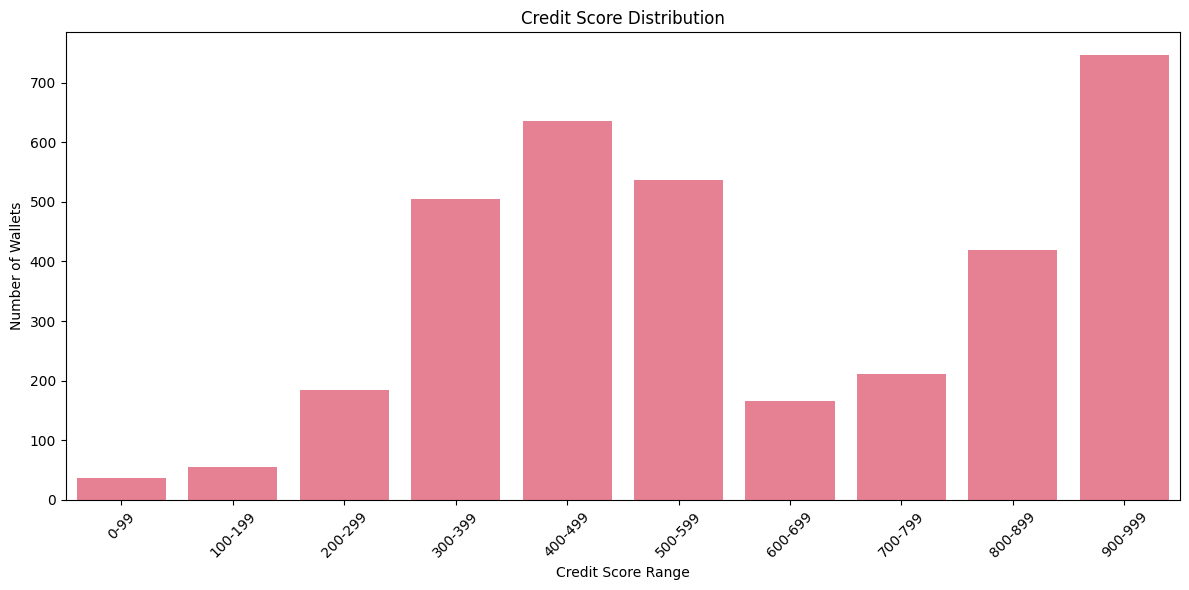


Top 5 Wallets by Credit Score:
                                          wallet  credit_score  tx_count  \
1077  0x01c4905e81eb6ebb919a802215b465137d1ba3a6          1000         1   
23    0x0002761e848b24046a53d494847b11a3e1d36b09           999         1   
130   0x0030de8f624d2b2513c6dbbff788bb109b80304d           999         1   
508   0x00c4fd7e8e4a9680b9db58640c76d4a17bd09ee4           999         1   
549   0x00d88be14e08e06865b156bb489e020a59cb68fe           999         1   

      deposit_value  borrow_value  liquidation_count  
1077   1.001085e+18           0.0                  0  
23     1.002262e+18           0.0                  0  
130    1.003159e+18           0.0                  0  
508    9.853084e+17           0.0                  0  
549    9.911826e+17           0.0                  0  

Bottom 5 Wallets by Credit Score:
                                          wallet  credit_score  tx_count  \
159   0x003be39433bde975b12411fbc3025d49d813a84f             0        

In [70]:

# Main execution
def main():
    # Load data
    print("Loading data...")
    file_path = '/content/user-wallet-transactions.json'
    df = load_data(file_path)

    # Preprocess data
    print("Preprocessing data...")
    df = preprocess_data(df)

    # Calculate wallet features
    print("Calculating wallet features...")
    wallet_features = calculate_wallet_features(df)

    # Generate credit scores
    print("Generating credit scores...")
    wallet_scores = generate_credit_scores(wallet_features)

    # Save results
    wallet_scores.to_csv('wallet_credit_scores.csv', index=False)

    # Analyze results
    print("Analyzing results...")
    analyze_scores(wallet_scores)

    print("Process completed successfully!")

if __name__ == "__main__":
    main()